In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import teotil3 as teo

plt.style.use("ggplot")

# Task 2.5: Estimate retention coefficients

From the proposal text:

> **Oppgave 2.5: Estimer retensjonskoeffisienter**
>
> Det vil bli satt sammen en database over innsjøer hvor både inn- og utløpstilførsler måles. Ved bruk av oppdaterte oppholdstider (Oppgave 2.4) vil retensjon i reginefeltskala estimeres ved å vurdere alle innsjøer langs hovedelvene i hvert nedbørfelt, antatt seriekoblet. Retensjonskoeffisienter for alle parametere (DIN, TON, TDP, TPP, SS og TOC) vil være basert på Vollenweider (1975) konseptet, med parameterspesifikke koeffisienter i utgangspunktet hentet fra litteraturen og deretter raffinert ved hjelp av observerte datasett.
>
> For underfraksjoner av N og P vil tilnærmingen som ble brukt i den opprinnelige TEOTIL-modellen for total N og P gi et utgangspunkt som alternativer (som å kalibrere N separat) kan evalueres mot.

## 1. Lake residence times

Task 2.4 identified lakes along the main river stem (above a certain size threshold) and estimated water residence times based on long-term mean flow rates. These residence times form the basis for retention estimates following the Vollenweider approach.

In [3]:
# Read dataset of residence times
dtm_res = 10
res_csv = f"../../data/lake_residence_times_{dtm_res}m_dem.csv"
df = pd.read_csv(res_csv)
df.head()

,regine,vatnLnr,area_km2,catch_area_km2,vol_Mm3,res_time_yr,accum_upstr_area_km2,local_a_cat_land_km2,accum_q_m3/s,local_q_cat_m3/s,a_upstr_reg_km2,is_main_stem,res_time_est_yr,mean_depth_m,hyd_load_mpyr
0,155.D1B,505,3.4267,16.06,130.487026,3.928855,16.075705,16.075705,1.05244,1.05244,0.0,1,3.928855,38.079501,9.692264
1,155.D4Z,42010,0.0572,1.81,0.052694,0.000330,84.137052,84.137052,5.06567,5.06567,0.0,1,0.000330,0.921225,2794.762021
2,155.31,45204,0.1385,3.26,1.139933,0.079323,8.240077,8.240077,0.45538,0.45538,0.0,1,0.079323,8.230560,103.759566
3,155.4G,45394,0.3475,1.73,1.912044,0.007599,137.563660,137.563660,7.97285,7.97285,0.0,1,0.007599,5.502285,724.040320
4,155.AD62,45290,0.0449,0.17,0.176800,0.004617,12.221607,12.221607,1.21335,1.21335,0.0,1,0.004617,3.937640,852.793184


## 2. Retention calculations

`teo.preprocessing` includes functions for implementing basic Vollenweider retention calculations for lakes and then aggregating values from lake- to regine-level. The methodology is as described in [Section 3.2 of the forprosjekt report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y#page=23). 

 * `calculate_lake_retention_vollenweider` caclulates lake-level retention based on retention times and parameter-specific Vollenweider parameters
 * `calculate_regine_retention` aggregates lake-level retention to regines
 * `assign_regine_retention` wraps the two functions above and applies them for all parameters of interest. Default Vollenweider parameters for each chemical variable of interest are defined here

## 3. Comparison with retention estimates from the original model

The original model only considered retention of total N and P. As far as I can tell, retention for these two parameters **at regine level** was estimated as described in [Section 3.2 of the forprosjekt report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y#page=23). For P, the Vollenweider parameters $\sigma = 1$ and $n = 0.5$ were used. Retention for N was then assumed to be 20% of retention for P, with an adjustment based on trophic status.

For comparison, the code below repeats these calculations using the new TEOTIL3 datasets.

In [4]:
# Retention for TOTN and TOTP using new model (but ignoring subfractions)
p_params = {
    "ind_var_col": "res_time_yr",
    "model": "sigma_from_tau",
    "k": 1,
    "p": 0.5,
}
n_params = {"ind_var_col": "hyd_load_mpyr", "model": "sigma_from_depth", "s": 4.5}
df = teo.preprocessing.calculate_lake_retention_vollenweider(df, "totp", p_params)
df = teo.preprocessing.calculate_lake_retention_vollenweider(df, "totn", n_params)

# Aggregate to regine level
reg_df = teo.preprocessing.calculate_regine_retention(
    df, regine_col="regine", pars=["totp", "totn"]
)

# Compare to old TEOTIL values
teo2_csv = r"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/core_input_data/retention_nutrients.csv"
old_df = pd.read_csv(teo2_csv, sep=";")
comp_df = pd.merge(reg_df, old_df, on="regine", how="inner")

print(f"There are {len(reg_df)} regines with non-zero retention in the new dataset.")
print(f"There are {len(old_df)} regines with non-zero retention in the old dataset.")
print(
    f"There are {len(comp_df)} regines with non-zero retention that can be matched between the two datasets."
)

comp_df = comp_df[["regine", "ret_totp", "ret_totn", "ret_tot-p", "ret_tot-n"]]
comp_df.columns = [
    "Regine",
    "New model TOTP",
    "New model TOTN",
    "Old model TOTP",
    "Old model TOTN",
]

display(comp_df.describe())

There are 9447 regines with non-zero retention in the new dataset.
There are 6559 regines with non-zero retention in the old dataset.
There are 4695 regines with non-zero retention that can be matched between the two datasets.


,New model TOTP,New model TOTN,Old model TOTP,Old model TOTN
count,4695.000000,4695.000000,4695.000000,4695.000000
mean,0.431864,0.150582,0.427538,0.099429
std,0.238053,0.152108,0.206965,0.061990
min,0.006080,0.000046,0.000000,0.000000
25%,0.232362,0.037105,0.260000,0.050000
50%,0.430681,0.101326,0.420000,0.090000
75%,0.618572,0.217057,0.580000,0.130000
max,0.994857,0.960284,0.980000,0.490000


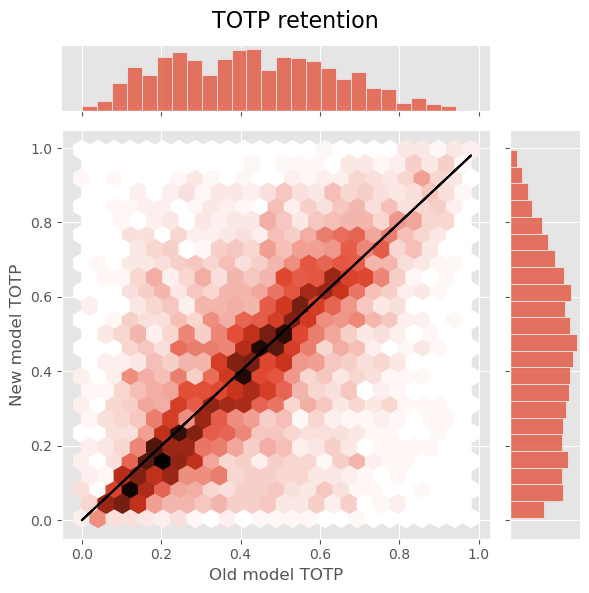

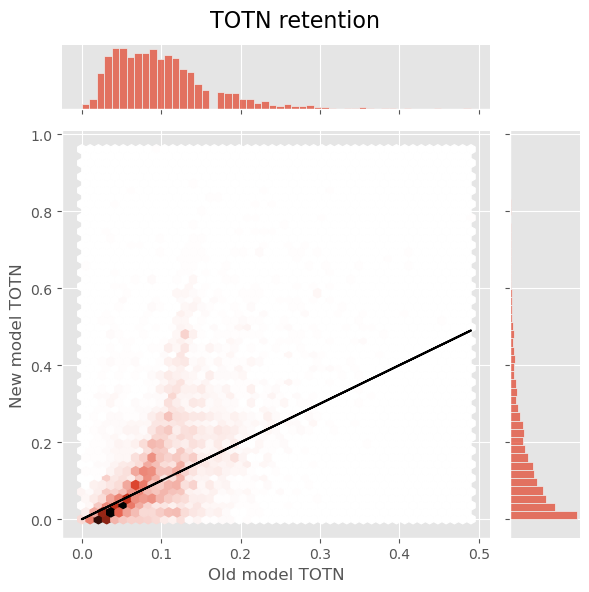

In [5]:
# Hexbin plots
for par in ["TOTP", "TOTN"]:
    g = sn.jointplot(
        data=comp_df, x=f"Old model {par}", y=f"New model {par}", kind="hex"
    )
    g.ax_joint.plot(comp_df[f"Old model {par}"], comp_df[f"Old model {par}"], "k-")
    g.fig.suptitle(f"{par} retention", fontsize=16)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.92)

Retention estimates for the new model are not expected to be the same as for the old one, because lake volumes and residence times have been estimated differently, and the method for identifying "main stem" lakes is probably also different (how this was done in the original model is not known). However, it is reassuring to see there is a generally good agreement between old and new values i.e. most of the joint density in the plots above lies along the 1:1 lines. The main difference is that the new model predicts high N retention for some lakes, which was not possible in the old model.

## 4. Estimate retention for new model parameters

The code below takes the latest model parameters defined in `assign_regine_retention` and calculates regine-level retention coefficients for the new model.

**Retention for kystfelt is assumed to be zero for all parameters**. The coastal regines often cover large areas of open sea and narrow coastal strips where the concept of a "main" river channel does not really make sense. This is especially the case when such areas include many small lakes, which taken together imply very low retention even though the total retention is likely small.

In [6]:
def is_kystfelt(code):
    """Return 1 if regine is a kystfelt (numeric code after decimal), otherwise zero."""
    try:
        int(code.split(".")[1])
        return True
    except ValueError:
        return False

In [7]:
# Read tidied regine data
data_fold = r"/home/jovyan/shared/common/teotil3/core_data"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_df = gpd.read_file(teo_gpkg, layer="regines", driver="GPKG")[["regine"]]

# Estimate retention and transmission
dtm_res = 10
reg_df = teo.preprocessing.assign_regine_retention(
    reg_df, regine_col="regine", dtm_res=dtm_res
)

# Set transmission = 1 and retention = 0 for kystfelt
trans_cols = [col for col in reg_df.columns if col.startswith("trans_")]
ret_cols = [col for col in reg_df.columns if col.startswith("ret_")]
mask = reg_df["regine"].apply(is_kystfelt)
reg_df.loc[mask, trans_cols] = 1
reg_df.loc[mask, ret_cols] = 0

# Save
csv_path = f"../../data/regine_retention_transmission_{dtm_res}m_dem.csv"
reg_df.to_csv(csv_path, index=False)

reg_df.head()

,regine,trans_totp,trans_tdp,trans_tpp,trans_totn,trans_din,trans_ton,trans_ss,trans_toc,ret_totp,ret_tdp,ret_tpp,ret_totn,ret_din,ret_ton,ret_ss,ret_toc
0,001.10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,001.1A1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,001.1A20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,001.1A2A,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,001.1A2B,0.142596,0.322305,0.039869,0.313131,0.247332,0.614118,0.000014,0.215819,0.857404,0.677695,0.960131,0.686869,0.752668,0.385882,0.999986,0.784181
